In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from data335 import lm, stan_lm, bambi_lm, mad

# 2. Linear regression

## Simple linear regression (GHV Chapters 6-9)

***Start of Lecture 4, 2025.01.20 (recorded 2025.01.18)***

### Today

- Sample from a simple linear regression model

- Fit a simple linear regression model

- Investigate distributions of parameter estimates

- Primary reference: GHV Chapter 6

### The model

$$
y_i = a + b x_i + \epsilon_i,\qquad \epsilon_i\sim N(0, \sigma^2)\qquad \text{(indep.)}
$$

#### Generate fake parameters and fake data



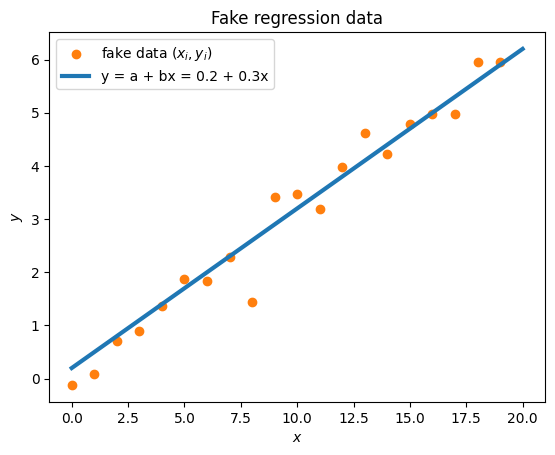

In [2]:
a = 0.2
b = 0.3
sigma = 0.5
n = 20
x = np.arange(n)
y = a + b * x + stats.norm(0, sigma).rvs(size=n)
plt.scatter(x, y, color="C1", label="fake data $(x_i, y_i)$")
plt.plot([0, 20], [a, a + b * 20], lw=3, label=f"y = a + bx = {a} + {b}x")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.title("Fake regression data")
plt.show()

#### Fit a `LinearRegression` model to the fake data

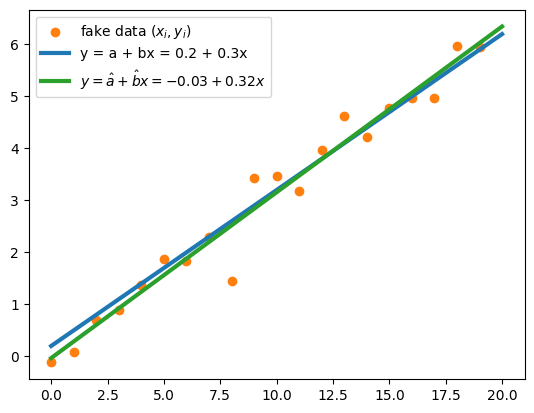

In [3]:
model = LinearRegression()
X = x.reshape(-1, 1)
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]
plt.scatter(x, y, color="C1", label="fake data $(x_i, y_i)$")
plt.plot([0, 20], [a, a + b * 20], color="C0", lw=3, label=f"y = a + bx = {a} + {b}x")
plt.plot(
    [0, 20],
    [ahat, ahat + bhat * 20],
    color="C2",
    lw=3,
    label=f"$y = \\hat{{a}} + \\hat{{b}}x = {ahat:.2f} + {bhat:.2f}x$",
)
plt.legend()
plt.show()

#### Uncertainty in regression coefficients

- The coefficients estimates $\hat{a}$ and $\hat{b}$ are random variables.

- We can generate their distributions by replicating our simulation.

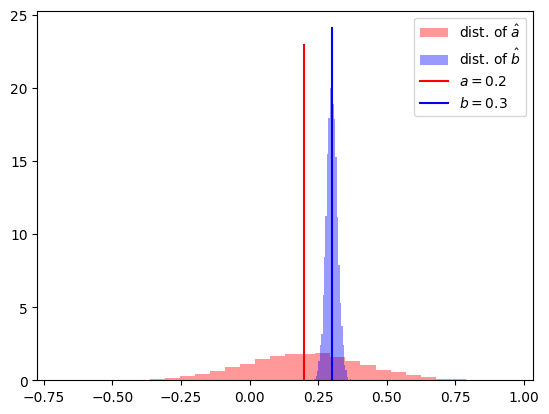

In [4]:
r = 10_000
epsilons = stats.norm(0, sigma).rvs(size=(n, r))
ys = a + b * X + epsilons
model = LinearRegression()
model.fit(X, ys)
ahats = model.intercept_
bhats = model.coef_[:, 0]
plt.hist(
    ahats, bins=30, color=(1, 0, 0, 0.4), density=True, label="dist. of $\\hat{a}$"
)
plt.hist(
    bhats, bins=30, color=(0, 0, 1, 0.4), density=True, label="dist. of $\\hat{b}$"
)
plt.plot([a, a], plt.ylim(), color=(1, 0, 0, 1), label=f"$a = {a}$")
plt.plot([b, b], plt.ylim(), color=(0, 0, 1, 1), label=f"$b = {b}$")
plt.legend()
plt.show()

- The distributions of $\hat{a}$ and $\hat{b}$ look normal because they are.

#### Residuals and estimating $\sigma$

Predicted $y$-values:
$$
\hat{y}_i = \hat{a} + \hat{b}x_i
$$

Residuals:
$$
\hat{y}_i - y_i
$$

Residual sum of squares:
$$
\operatorname{RSS} = \sum_{i < n}(\hat{y}_i - y_i)^2
$$

Estimate $\sigma^2$:
$$
s^2 = \frac{\operatorname{RSS}}{n - 2}
$$

$s$ is called the **residual standard error**.

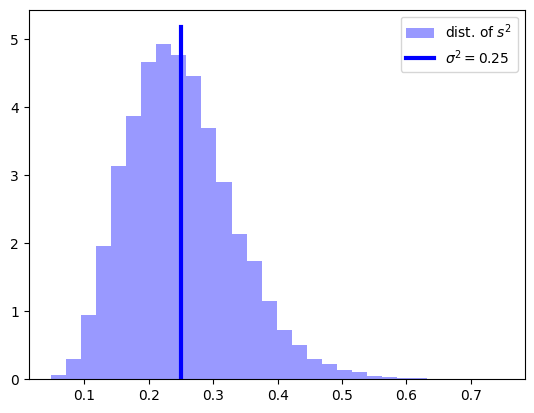

In [5]:
yhats = model.predict(X)
rsss = np.sum((yhats - ys) ** 2, axis=0)
s2s = rsss / (n - 2)
plt.hist(s2s, bins=30, density=True, color=(0, 0, 1, 0.4), label="dist. of $s^2$")
plt.plot(
    [sigma**2, sigma**2],
    plt.ylim(),
    color=(0, 0, 1),
    lw=3,
    label=f"$\\sigma^2={sigma**2}$",
)
plt.legend()
plt.show()

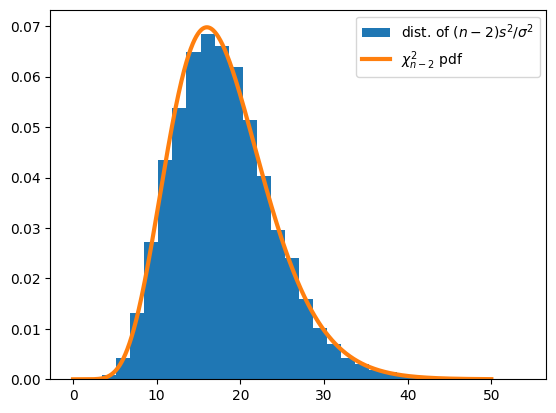

In [6]:
plt.hist(
    (n - 2) * s2s / sigma**2,
    bins=30,
    density=True,
    label="dist. of $(n-2)s^2/\\sigma^2$",
)
mesh = np.linspace(0, 50, 1000)
plt.plot(mesh, stats.chi2(n - 2).pdf(mesh), lw=3, label="$\\chi^2_{n-2}$ pdf")
plt.legend()
plt.show()

- The `LinearRegression` class doesn't compute standard errors for coefficient estimates because `scikit-learn` doesn't concern itself with statistical inference.

***End of Lecture 4, 2025.01.20 (recorded 2025.01.18)***

***Start of Lecture 5, 2025.01.22***

### Today

- Questions from Lab 1

- Simple linear regression examples with real data (GHV &sect;6.4)

- *Regression to the mean* and the *regression fallacy* (GHV &sect;6.5)

#### Lab 1

In [7]:
# Lab warm-up exercise #2
d = stats.norm(0, 1)
print(d.cdf(1) - d.cdf(-1))
x = d.ppf(0.8)
print(d.cdf(x) - d.cdf(-x))

0.6826894921370859
0.6000000000000001


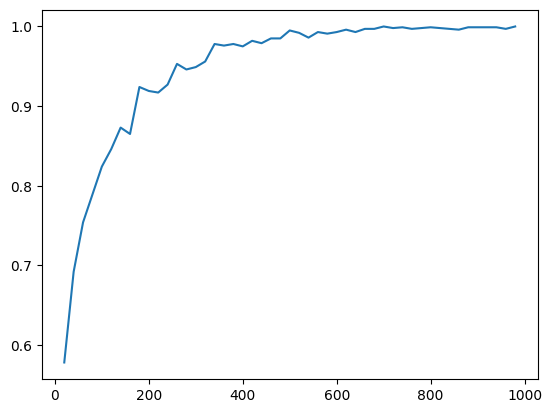

In [8]:
# GHV Exercise 4.4
m = 1000
ns = np.arange(20, 1000, 20)

correct = []
for n in ns:
    y = stats.binom(n, 0.4).rvs(size=m)
    correct.append(np.mean(y > 0.35 * n))
plt.plot(ns, correct)

In [9]:
def f(p, r, n):
    x = stats.bernoulli(r).rvs(n)
    y = stats.bernoulli(p).rvs(n)
    return x, y

### Simple linear regression examples with real data

#### Heights of mothers and daughters

In [10]:
df = pd.read_csv("../data/heights.csv")
df

,daughter_height,mother_height
0,52.5,59.5
1,52.5,59.5
2,53.5,59.5
3,53.5,59.5
4,55.5,59.5
...,...,...
5519,71.5,70.5
5520,73.5,63.5
5521,73.5,63.5
5522,73.5,63.5


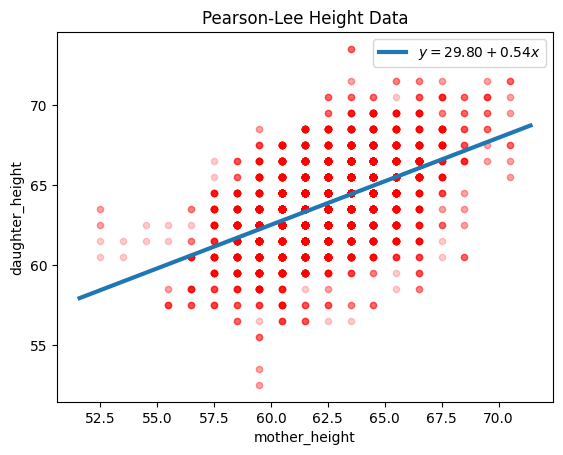

In [11]:
df.plot.scatter("mother_height", "daughter_height", color=(1, 0, 0, 0.2))

X = df[["mother_height"]]
y = df["daughter_height"]
model = LinearRegression()
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]
xmin, xmax = plt.xlim()
plt.plot(
    [xmin, xmax],
    [ahat + bhat * xmin, ahat + bhat * xmax],
    lw=3,
    label=f"$y = {ahat:.2f} + {bhat:.2f}x$",
)
plt.legend()
plt.title("Pearson-Lee Height Data")
plt.show()

- Interpreting the slope: Daughters of mothers with height $x + 1$ are, on average, $0.54$ inches taller than mother with height $x$.

- Since people can't be zero inches tall, the intercept's natural interpretation isn't particularly compelling in this example.

#### Regression to the mean

- Linear regression fit to mother/daughter height data:
$$
y - \underset{\bar{y}}{63.9} = \underset{\widehat{b}}{0.54}(x−\underset{\bar{x}}{62.5})
$$

- Daughters of tall (short) mothers tend to be taller (shorter) than average but shorter (taller) than their
mothers.

- From one generation to the next, heights "regress to the mean".

- The regression "paradox": Why doesn't the variability in height decrease over generations?

#### The regression fallacy

- interpreting regression to the mean causally.

- Examples:

   - Scoring highly on the midterm leads to overconfidence and underperforming on the final exam.

   - Negative reinforcement is more effective than positive reinforcement.

   - Sophomore slump. Sports Illustrated cover jinx. Madden curse. [More examples](https://en.wikipedia.org/wiki/Regression_toward_the_mean#Regression_fallacies).

***End of Lecture 5, 2025.01.22***

***Start of Lecture 6, 2025.01.24***

### Today

- Forecasting elections from the economy (GHV &sect;7.1)

- Formulating comparisons as regression models (GHV &sect;7.3)

#### Forecasting elections from the economy

> "[It's the economy, stupid!](https://en.wikipedia.org/wiki/It%27s_the_economy,_stupid)"
> James Carville, 1992

<img src="https://www.hup.harvard.edu/img/feeds/jackets/9780674027367.png" height="300px">

In [12]:
# Load dataframe with pandas
df = pd.read_csv("../data/hibbs.csv")
df

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon
5,1972,3.62,61.79,Nixon,McGovern
6,1976,1.08,48.95,Ford,Carter
7,1980,-0.39,44.70,Carter,Reagan
8,1984,3.86,59.17,Reagan,Mondale
9,1988,2.27,53.94,"Bush, Sr.",Dukakis


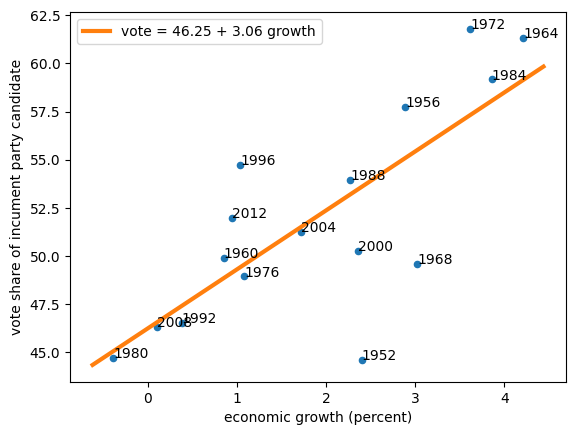

In [13]:
# Scatter plot and regression line
df.plot.scatter("growth", "vote")
plt.xlabel("economic growth (percent)")
plt.ylabel("vote share of incument party candidate")

for _, row in df.iterrows():
    plt.annotate(row["year"], (row["growth"], row["vote"]))

model = LinearRegression()
X = df[["growth"]]
y = df["vote"]
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]
xmin, xmax = plt.xlim()
plt.plot(
    [xmin, xmax],
    [ahat + bhat * xmin, ahat + bhat * xmax],
    lw=3,
    color="C1",
    label=f"vote = {ahat:.2f} + {bhat:.2f} growth",
)
plt.legend()
plt.show()

In [14]:
yhat = model.predict(X)
rss = np.sum((yhat - y) ** 2)
print(f"rss = {rss:.2f}")
n = len(df)
s = np.sqrt(rss / (n - 2))
print(f"s = {s:.2f}")

rss = 198.27
s = 3.76


##### What does the model predict for the 2016 election?

- Clinton represented the incumbent Democratic party. Trump was the Republican candidate.

- Economic growth in 2016 was 2%, so $x=2$.

- Model:
$$
y\sim N(a + bx,\sigma^2)\approx N(\hat{a} + \hat{b}x, s^2)\\
$$
- Probability of Trump victory:
$$
\begin{aligned}
\mathbb{P}[y < 50] &= \operatorname{cdf}_{N(a + bx,\sigma^2)}(50)\\
&\approx \operatorname{cdf}_{N(\hat{a} + \hat{b}x, s^2)}(50)
\end{aligned}
$$

In [15]:
expected_vote_for_clinton = ahat + bhat * 2
print(f"vote = {expected_vote_for_clinton:.2f}")
prob_trump_wins = stats.norm(expected_vote_for_clinton, s).cdf(50)
print(f"prob_trump_wins = {prob_trump_wins:.2f}")

vote = 52.37
prob_trump_wins = 0.26


In [16]:
x = np.array([1, 2, -5, 2, 1, 0])
assert x[x.argmin()] == x.min()

#### Formulating comparisons as regression models (GHV &sect;7.3)

Fitting a simple linear regression model:
$$
(\hat{a}, \hat{b}) = \argmin_{(a, b)}
\sum_{i<n} (a + bx_i - y_i)^2
$$

##### Estimating the mean is the same as regressing on a constant term

- If $b=0$, this becomes
   $$
   \hat{a}=\argmin_{a}
   \sum_{i<n} (a - y_i)^2.
   $$
   The solution of this optimization problem is $\hat{a}=\bar{y}$.

- `sklearn.linear_model.LinearRegression` won't let you fit a model with no predictors, but you can fake it by letting the feature matrix `X` be all zeros

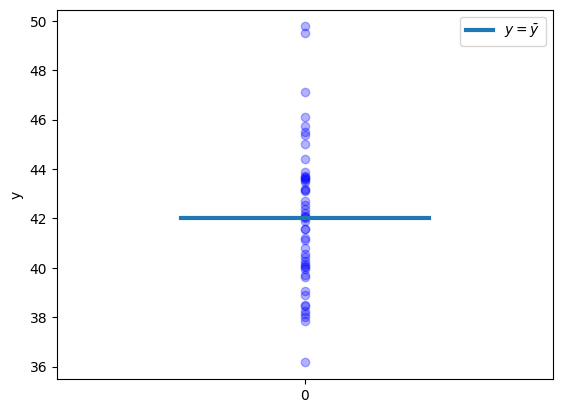

In [17]:
y = stats.norm(42, 3).rvs(size=50)
X = np.zeros((50, 1))
model = LinearRegression()
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]
assert np.allclose(ahat, y.mean())
assert np.allclose(bhat, 0)

plt.scatter(X.squeeze(), y, color=(0, 0, 1, 0.3))
plt.xlim(-1, 1)
plt.xticks([0])
plt.ylabel("y")
plt.plot([-0.5, 0.5], [ahat, ahat], lw=3, label=f"$y = \\bar{{y}}$")
plt.legend()
plt.show()

##### Estimating a difference is the same as regressing on an indicator variable

- Suppose $x$ is an indicator variable: $x_i\in \{0, 1\}$. Then
   $$
   \sum_{i} (a + bx_i - y_i)^2 = \sum_{x_i = 0}(a - y_i)^2 + \sum_{x_i = 1}(a + b - y_i)^2
   $$

- Minimized for
   $$
   \hat{a} =\frac1{n_0}\sum_{x_i = 0} y_i,\qquad
   \hat{a} + \hat{b} = \frac1{n_1}\sum_{x_i = 1} y_i,\qquad
   $$
   where $n_0=\#\{i : x_i = 0\}$ and $n_1=\#\{i : x_i = 1\}$.

- The slope $\hat{b}$ is the difference of group sample means:
  $$
  \hat{b} = \frac1{n_1}\sum_{x_i = 1} y_i - \frac1{n_0}\sum_{x_i = 0} y_i
  $$



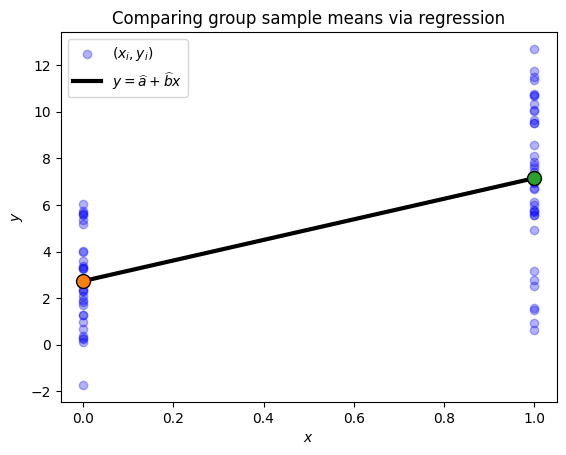

In [18]:
n0 = 30
n1 = 40
y0 = stats.norm(3, 2).rvs(size=n0)
y1 = stats.norm(8, 3).rvs(size=n1)
y = np.concatenate([y0, y1])
X = np.concatenate([np.zeros_like(y0), np.ones_like(y1)]).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]
assert np.allclose(bhat, y1.mean() - y0.mean())

plt.scatter(X.squeeze(), y, color=(0, 0, 1, 0.3), label="$(x_i, y_i)$")
plt.plot(
    [0, 1],
    [y0.mean(), y1.mean()],
    "k",
    lw=3,
    label=f"$y=\\widehat{{a}} + \\widehat{{b}}x$",
)
plt.plot(0, y0.mean(), "o", color="C1", ms=10, mec="k")
plt.plot(1, y1.mean(), "o", color="C2", ms=10, mec="k")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Comparing group sample means via regression")
plt.legend()
plt.show()

***End of Lecture 6, 2025.01.24***

***Start of Lecture 7, 2025.01.27***

### Lecture 7

- Uncertainty in regression coefficients

- Bayesian inference (first look)

- Stan, PyMC, Bambi, and rstanarm

- Posterior probabilities and predictions

#### Uncertainty in regression coefficients

- `sklearn` models produce coefficient estimates but say about uncertainty in these estimates.

- We need uncertainty estimates to do statistical inference.

- For simple linear regression, we have:

  $$
  \operatorname{se}({\hat{b}}) = \dfrac{s}{\sqrt{\sum_{i<n}(x_i-\bar{x})^2}},\qquad
  \operatorname{se}({\hat{a}}) = {\operatorname{se}({\hat{b}})}\sqrt{\frac{1}{n}\sum_{i < n}x_i^2}
  $$

- We can work these out for the Hibbs US election dataset.

In [19]:
# Copy-pasted from last class
hibbs = pd.read_csv("../data/hibbs.csv")
n = len(hibbs)
model = LinearRegression()
X = hibbs[["growth"]].to_numpy()
y = hibbs["vote"]
model.fit(X, y)
ahat = model.intercept_
bhat = model.coef_[0]
yhat = model.predict(X)
rss = np.sum((yhat - y) ** 2)
s = np.sqrt(rss / (n - 2))

# New stuff
sebhat = s / np.sqrt(np.sum((X - X.mean()) ** 2))
seahat = sebhat * np.sqrt(np.sum(X**2) / n)
print(f"ahat = {ahat:.6f}, seahat = {seahat:.6f}")
print(f"bhat = {bhat:.6f}, sebhat = {sebhat:.6f}")
print(f"s = {s:.6f}")

ahat = 46.247648, seahat = 1.621931
bhat = 3.060528, sebhat = 0.696274
s = 3.763288


- If you use `statsmodels` ([statsmodels.org](https://www.statsmodels.org/stable/index.html)) instead of `sklearn`, you'll get error estimates.

- Or just use the R-style `lm` function from the `data335` module (minimal, naïve implementation).

In [20]:
lm(hibbs, features=["growth"], target="vote")

,estimate,standard error,t-statistic,p-value
(Intercept),46.247648,1.621931,28.513936,0.0
growth,3.060528,0.696274,4.395581,0.00061
sigma,3.763288,,,


#### Stan and `stan_glm`

- GHV emphasizes the *Bayesian* (as opposed to *frequentist*) approach to inference, uses the R function `stan_glm` from the `rstanarm` package to fit (generalized) linear models.

- The "heavy lifting" is done using [Stan: Software for Bayesian Data Analysis](https://mc-stan.org).

- `stan_glm` calls out to the `rstan` library which is responsible for marshalling data between R and Stan.

<figure style="display: flex; flex-direction: column; align-items: center">
<img src="https://github.com/mgreenbe/DATA335W2025/blob/main/assets/stan_glm_vote_growth.png?raw=true" width="300px">
<figcaption>Figure: Output of <code>stan_glm(vote ~ growth, data=hibbs)</code> (GHV p. 94)</figcaption>
</figure>

In [21]:
stan_lm_fit = stan_lm(hibbs, target="vote", features=["growth"])
stan_lm_fit

13:38:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:38:41 - cmdstanpy - INFO - CmdStan done processing.


,median,mad_sd
Intercept,46.27135,1.696986
growth,3.04978,0.762406
sigma,4.01728,0.832896


In [22]:
bambi_lm_fit = bambi_lm("vote ~ growth", hibbs)
bambi_lm_fit

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, growth]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,median,mad_sd
sigma,3.935407,0.743487
Intercept,46.315190,1.784771
growth,3.030556,0.774775


- The differences between the uncertainty estimates from `rstanarm::stan_glm` and from `data335.stan_lm` are due to their different choices of *priors*.

#### Bayesian Inference

- Least squares fits a model by finding the paramter values that best fit the data.

- Bayesian inference encodes distills information about the paramters &mdash; coming both from the data and from any prior knowledge &mdash; into a probability distributino called the **posterior distribution**.
  
- Rather than being characterized by an explicit formula, the posterior distribution is usually described by a collection of *samples* or *draws* produced through simulation via *Markov-chain Monte Carlo* algorithms.

In [23]:
stan_lm_fit.draws

,Intercept,growth,sigma
0,47.2876,2.36943,4.24601
1,47.5626,3.30297,3.99115
2,47.2482,2.98043,4.70411
3,45.7800,3.18855,3.27199
4,46.1692,3.08080,3.53589
...,...,...,...
3995,44.4288,3.07381,3.55783
3996,46.5901,3.36793,2.94051
3997,45.2481,3.36411,3.02194
3998,46.9849,2.92213,3.47100


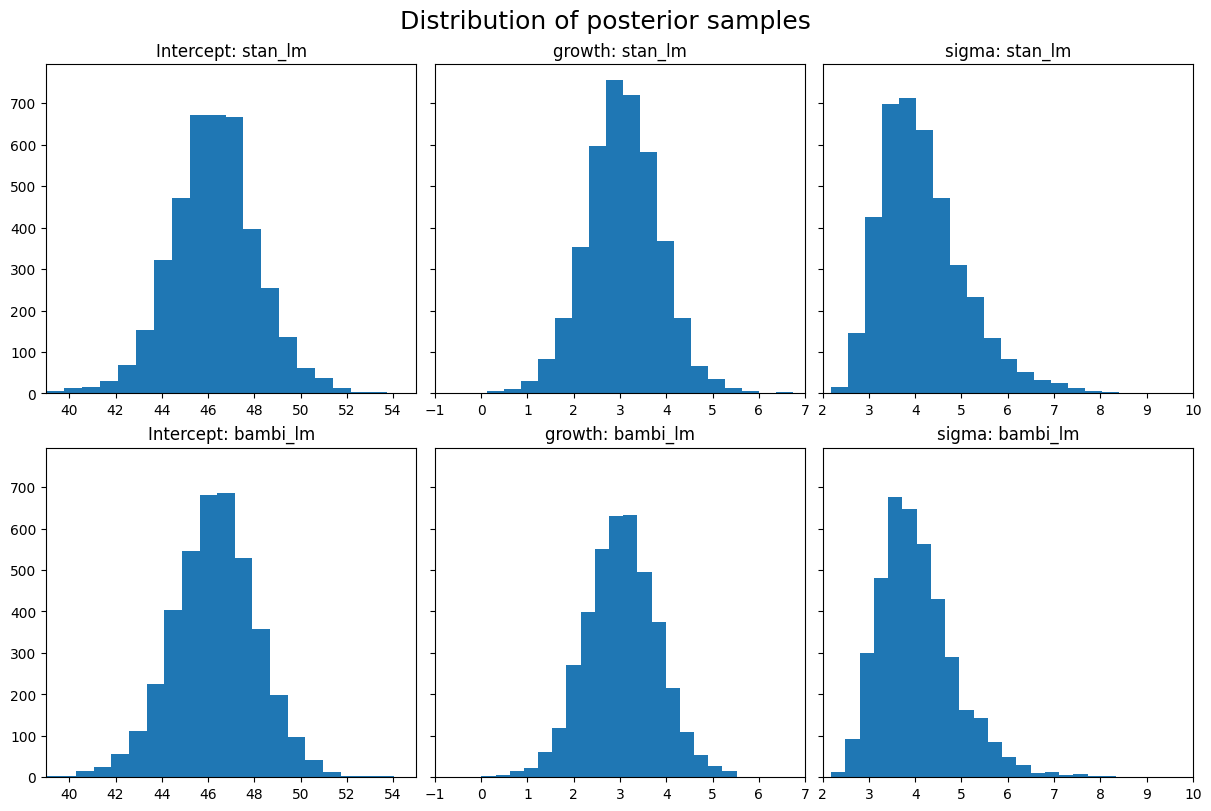

In [24]:
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(12, 8), sharey=True, layout="constrained"
)
fig.suptitle("Distribution of posterior samples", fontsize=18)
cols = ["Intercept", "growth", "sigma"]

xmins = {}
xmaxs = {}
for col in cols:
    xmin = min(stan_lm_fit.draws[col].min(), stan_lm_fit.draws[col].min())
    xmax = max(stan_lm_fit.draws[col].max(), stan_lm_fit.draws[col].max())
    xmins[col] = np.floor(xmin)
    xmaxs[col] = np.ceil(xmax)

for ax, col in zip(axes[0], cols):
    x = stan_lm_fit.draws[col]
    ax.hist(x, bins=20)
    ax.set_xlim(xmins[col], xmaxs[col])
    ax.set_title(f"{col}: stan_lm")

for ax, col in zip(axes[1], cols):
    x = bambi_lm_fit.draws[col]
    ax.hist(x, bins=20)
    ax.set_xlim(xmins[col], xmaxs[col])
    ax.set_title(f"{col}: bambi_lm")

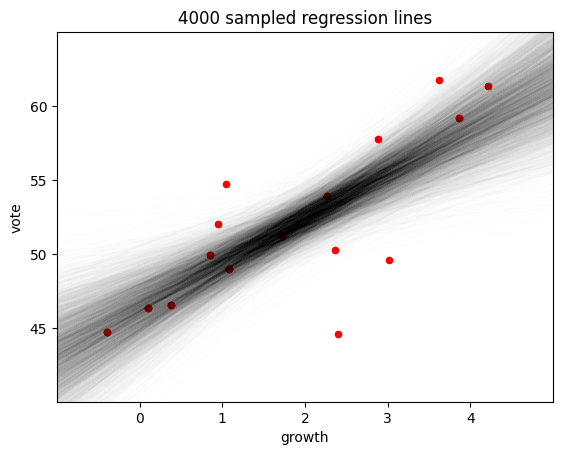

In [25]:
hibbs.plot.scatter("growth", "vote", color="red")
xmin = -1
xmax = 5
plt.xlim(xmin, xmax)
plt.xticks([0, 1, 2, 3, 4])
plt.ylim(40, 65)
plt.yticks([45, 50, 55, 60])
draws = bambi_lm_fit.draws
for a, b in zip(draws["Intercept"], draws["growth"]):
    plt.plot([xmin, xmax], [a + b * xmin, a + b * xmax], color=(0, 0, 0, 0.005))
plt.title(f"{len(draws)} sampled regression lines")
plt.show()

#### Posterior probabilities

- Since the regression slope $b$ is a random variable, we can evaluate probability that it lies in a certain range.

- For the Hibbs election data as fit above:
  $$
  \mathbb{P}[b > 2] \approx 0.92.
  $$

- "Bayesian hypothesis testing"

In [26]:
np.mean(stan_lm_fit.draws["growth"] > 2), np.mean(bambi_lm_fit.draws["growth"] > 2)

(0.9145, 0.908)

#### Uncertainty/credible intervals

- Bayesian version of confidence intervals

- quantiles of the posterior

In [27]:
low, hight = np.quantile(stan_lm_fit.draws["growth"], [0.05, 0.95])
print(f"95%-interval for growth coefficient = [{low:.2f}, {hight:.2f}]")

95%-interval for growth coefficient = [1.75, 4.35]


#### Posterior predictive distribution

Prob[vote < 50] = 0.27
median(vote) = 52.41, mad_sd(vote) = 4.08


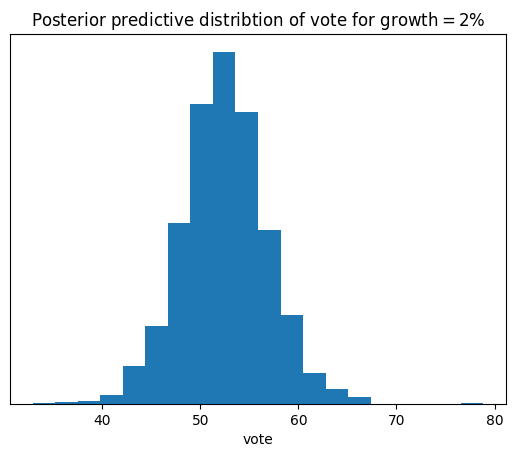

In [28]:
sigma = stan_lm_fit.draws["sigma"]
growth = stan_lm_fit.draws["growth"]
intercept = stan_lm_fit.draws["Intercept"]
error = stats.norm(0, sigma).rvs()

vote = intercept + growth * 2 + error
print(f"Prob[vote < 50] = {np.mean(vote < 50):.2f}")
median = np.median(vote)
mad_sd = mad(vote)
print(f"median(vote) = {median:.2f}, mad_sd(vote) = {mad_sd:.2f}")
plt.hist(vote, bins=20)
plt.xlabel("vote")
plt.yticks([])
plt.title(
    "Posterior predictive distribtion of $\\text{vote}$ for $\\text{growth}=2\\%$"
)
plt.show()

#### Posterior, Likelihood, Prior

- **Bayes Theorem** gives a factorization of the posterior:
  $$
  \underset{\text{posterior}}{p(\text{paramters}\mid\text{data})} \propto 
  \underset{\text{likelihood}}{p(\text{data}\mid\text{parameters})}
  \underset{\text{prior}}{p(\text{parameters})}
  $$

- For simple linear regression:
  $$
  p(a, b, \sigma\mid y_0,\ldots,y_{n-1}) \propto p(y_0,\ldots,y_{n-1}\mid a, b, \sigma)p(a, b, \sigma)
  $$

- According to the simple linear regression model, the $x_i$ are considered *known quantities*, neither random variables (like the $y_i$) nor paramters (like $a$, $b$, and $\sigma$).

- *Likelihoods* are probability mass or density functions:
  $$
  p(y_0,\ldots,y_{n-1}\mid a, b, \sigma) = \prod_{i < n}\frac1{\sqrt{2\pi}\sigma}\exp\left(-\frac1{2\sigma^2}(a + bx_i - y_i)^2\right)
  $$

- The prior summarizes what we (don't) know about the paramters prior to seeing the data.